In [62]:
import pandas as pd
import seaborn as sns
from scipy.stats import skew, kurtosis
import plotly.express as px
import numpy as np
from pandas.api.types import infer_dtype
import geopy
import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import GridSearchCV
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from scipy.stats import uniform, randint
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import pydot_ng as pydot
from IPython.display import Image
import math
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [7]:
df = pd.read_csv('LADOT_Metered_Parking_Inventory___Policies.csv')
df_inv = pd.read_csv('Sensor_Transactions_2022_12.csv')

In [12]:
#Look at the data to see the columns and the form in which the data is represented
df.head()
df_inv.head()

,SpaceID,EventTime_Local,EventTime_UTC,OccupancyState
0,CB1317,12/1/2022 12:00:00 AM,12/1/2022 8:00:00 AM,VACANT
1,CT319,12/1/2022 12:00:01 AM,12/1/2022 8:00:01 AM,VACANT
2,CC822,12/1/2022 12:00:01 AM,12/1/2022 8:00:01 AM,VACANT
3,CC1501,12/1/2022 12:00:02 AM,12/1/2022 8:00:02 AM,VACANT
4,LT564,12/1/2022 12:00:02 AM,12/1/2022 8:00:02 AM,VACANT


In [9]:
#Check the spaceIDs to see the number of unique meters we have in the occupancy dataset
len(df["SpaceID"].unique())
len(df_inv["SpaceID"].unique())

4207

In [13]:
#Check the missing values in both dataframes
df.isnull().sum()
df_inv.isnull().sum()

SpaceID                 0
BlockFace               0
MeterType               0
RateType                0
RateRange               0
MeteredTimeLimit        0
ParkingPolicy           0
StreetCleaning      24375
LatLng                  0
dtype: int64

In [15]:
#Check the two datasets to find the parking IDs that are in the occupancy dataset that arent in the inventory
A = df["SpaceID"].unique()
B = df_inv["SpaceID"].unique()

diff = np.setdiff1d(B,A)
print(len(diff))


195


In [16]:
#remove all the space ID's that are not in the inventory dataset
df_inv = df_inv[~(df_inv.SpaceID.isin(diff))]

In [17]:
#Merge the datasets based on the spaceIDs
df_merged = pd.merge(df, df_inv, on=["SpaceID"])

In [19]:
#Check to see the structure of the merged dataset
df_merged.head()

,SpaceID,BlockFace,MeterType,RateType,RateRange,MeteredTimeLimit,ParkingPolicy,StreetCleaning,LatLng,EventTime_Local,EventTime_UTC,OccupancyState
0,61128,201 S MAIN ST,Multi-Space,FLAT,$1.00,2HR,8A-6P Daily,10A-12P Mon,"(33.996329, -118.478016)",12/1/2022 1:43:54 PM,12/1/2022 9:43:54 PM,VACANT
1,61128,201 S MAIN ST,Multi-Space,FLAT,$1.00,2HR,8A-6P Daily,10A-12P Mon,"(33.996329, -118.478016)",12/1/2022 2:17:43 PM,12/1/2022 10:17:43 PM,OCCUPIED
2,61128,201 S MAIN ST,Multi-Space,FLAT,$1.00,2HR,8A-6P Daily,10A-12P Mon,"(33.996329, -118.478016)",12/1/2022 2:17:48 PM,12/1/2022 10:17:48 PM,VACANT
3,61128,201 S MAIN ST,Multi-Space,FLAT,$1.00,2HR,8A-6P Daily,10A-12P Mon,"(33.996329, -118.478016)",12/1/2022 2:51:12 PM,12/1/2022 10:51:12 PM,OCCUPIED
4,61128,201 S MAIN ST,Multi-Space,FLAT,$1.00,2HR,8A-6P Daily,10A-12P Mon,"(33.996329, -118.478016)",12/1/2022 2:53:42 PM,12/1/2022 10:53:42 PM,VACANT


In [28]:
#Check for null values in the merged dataset
df_merged.isnull().sum()

SpaceID             0
BlockFace           0
MeterType           0
RateType            0
RateRange           0
MeteredTimeLimit    0
ParkingPolicy       0
StreetCleaning      0
LatLng              0
EventTime_Local     0
EventTime_UTC       0
OccupancyState      0
dtype: int64

In [21]:
#Convvert the MeteredTimeLimit column to float
limit = []
for i in df_merged["MeteredTimeLimit"]:
    if "MIN" in i:
        r = i.replace("MIN", "")
        r = int(r)/60
        limit.append(round(r, 2))
    else:
        i = i.replace("HR", "")
        limit.append(float(i))
        
df_merged["MeteredTimeLimit"] = limit
df_merged.head()

,SpaceID,BlockFace,MeterType,RateType,RateRange,MeteredTimeLimit,ParkingPolicy,StreetCleaning,LatLng,EventTime_Local,EventTime_UTC,OccupancyState
0,61128,201 S MAIN ST,Multi-Space,FLAT,$1.00,2.0,8A-6P Daily,10A-12P Mon,"(33.996329, -118.478016)",12/1/2022 1:43:54 PM,12/1/2022 9:43:54 PM,VACANT
1,61128,201 S MAIN ST,Multi-Space,FLAT,$1.00,2.0,8A-6P Daily,10A-12P Mon,"(33.996329, -118.478016)",12/1/2022 2:17:43 PM,12/1/2022 10:17:43 PM,OCCUPIED
2,61128,201 S MAIN ST,Multi-Space,FLAT,$1.00,2.0,8A-6P Daily,10A-12P Mon,"(33.996329, -118.478016)",12/1/2022 2:17:48 PM,12/1/2022 10:17:48 PM,VACANT
3,61128,201 S MAIN ST,Multi-Space,FLAT,$1.00,2.0,8A-6P Daily,10A-12P Mon,"(33.996329, -118.478016)",12/1/2022 2:51:12 PM,12/1/2022 10:51:12 PM,OCCUPIED
4,61128,201 S MAIN ST,Multi-Space,FLAT,$1.00,2.0,8A-6P Daily,10A-12P Mon,"(33.996329, -118.478016)",12/1/2022 2:53:42 PM,12/1/2022 10:53:42 PM,VACANT


In [22]:
#infer the datatype for each column 
df_merged = df_merged.convert_dtypes()
df_merged.dtypes

SpaceID             string[python]
BlockFace           string[python]
MeterType           string[python]
RateType            string[python]
RateRange           string[python]
MeteredTimeLimit           Float64
ParkingPolicy       string[python]
StreetCleaning      string[python]
LatLng              string[python]
EventTime_Local     string[python]
EventTime_UTC       string[python]
OccupancyState      string[python]
dtype: object

In [23]:
#value conversion 
df_merged["MeterType"].replace('Multi-Space', 'M', inplace=True)
df_merged["MeterType"].replace('Single-Space', 'S', inplace=True)
df_merged.head()

,SpaceID,BlockFace,MeterType,RateType,RateRange,MeteredTimeLimit,ParkingPolicy,StreetCleaning,LatLng,EventTime_Local,EventTime_UTC,OccupancyState
0,61128,201 S MAIN ST,M,FLAT,$1.00,2.0,8A-6P Daily,10A-12P Mon,"(33.996329, -118.478016)",12/1/2022 1:43:54 PM,12/1/2022 9:43:54 PM,VACANT
1,61128,201 S MAIN ST,M,FLAT,$1.00,2.0,8A-6P Daily,10A-12P Mon,"(33.996329, -118.478016)",12/1/2022 2:17:43 PM,12/1/2022 10:17:43 PM,OCCUPIED
2,61128,201 S MAIN ST,M,FLAT,$1.00,2.0,8A-6P Daily,10A-12P Mon,"(33.996329, -118.478016)",12/1/2022 2:17:48 PM,12/1/2022 10:17:48 PM,VACANT
3,61128,201 S MAIN ST,M,FLAT,$1.00,2.0,8A-6P Daily,10A-12P Mon,"(33.996329, -118.478016)",12/1/2022 2:51:12 PM,12/1/2022 10:51:12 PM,OCCUPIED
4,61128,201 S MAIN ST,M,FLAT,$1.00,2.0,8A-6P Daily,10A-12P Mon,"(33.996329, -118.478016)",12/1/2022 2:53:42 PM,12/1/2022 10:53:42 PM,VACANT


In [24]:
#Datatype conversion for the EventTime_local column
df_merged["Date"]= pd.to_datetime(df_merged["EventTime_Local"], format='mixed')

In [25]:
#rename the date column and drop the two other date columns
df_merged.rename(columns = {'Date':'EventTime'}, inplace = True)
df_merged.drop(['EventTime_UTC', "EventTime_Local"], axis=1, inplace=True)
df_merged.head()

,SpaceID,BlockFace,MeterType,RateType,RateRange,MeteredTimeLimit,ParkingPolicy,StreetCleaning,LatLng,OccupancyState,EventTime
0,61128,201 S MAIN ST,M,FLAT,$1.00,2.0,8A-6P Daily,10A-12P Mon,"(33.996329, -118.478016)",VACANT,2022-12-01 13:43:54
1,61128,201 S MAIN ST,M,FLAT,$1.00,2.0,8A-6P Daily,10A-12P Mon,"(33.996329, -118.478016)",OCCUPIED,2022-12-01 14:17:43
2,61128,201 S MAIN ST,M,FLAT,$1.00,2.0,8A-6P Daily,10A-12P Mon,"(33.996329, -118.478016)",VACANT,2022-12-01 14:17:48
3,61128,201 S MAIN ST,M,FLAT,$1.00,2.0,8A-6P Daily,10A-12P Mon,"(33.996329, -118.478016)",OCCUPIED,2022-12-01 14:51:12
4,61128,201 S MAIN ST,M,FLAT,$1.00,2.0,8A-6P Daily,10A-12P Mon,"(33.996329, -118.478016)",VACANT,2022-12-01 14:53:42


In [26]:
#Remove the rows in the occupancyState columns where the value is unknown
unknown = df_merged[df_merged['OccupancyState'] == "UNKNOWN"].index
df_merged.drop(unknown , inplace=True)

In [27]:
# convert the label class to numbers
df_merged["OccupancyState"].replace({"VACANT":"1", "OCCUPIED":"0"}, inplace=True)
df_merged.head()

,SpaceID,BlockFace,MeterType,RateType,RateRange,MeteredTimeLimit,ParkingPolicy,StreetCleaning,LatLng,OccupancyState,EventTime
0,61128,201 S MAIN ST,M,FLAT,$1.00,2.0,8A-6P Daily,10A-12P Mon,"(33.996329, -118.478016)",1,2022-12-01 13:43:54
1,61128,201 S MAIN ST,M,FLAT,$1.00,2.0,8A-6P Daily,10A-12P Mon,"(33.996329, -118.478016)",0,2022-12-01 14:17:43
2,61128,201 S MAIN ST,M,FLAT,$1.00,2.0,8A-6P Daily,10A-12P Mon,"(33.996329, -118.478016)",1,2022-12-01 14:17:48
3,61128,201 S MAIN ST,M,FLAT,$1.00,2.0,8A-6P Daily,10A-12P Mon,"(33.996329, -118.478016)",0,2022-12-01 14:51:12
4,61128,201 S MAIN ST,M,FLAT,$1.00,2.0,8A-6P Daily,10A-12P Mon,"(33.996329, -118.478016)",1,2022-12-01 14:53:42


In [28]:
#convert the OccupancyState Column to integers
df_merged["OccupancyState"] = df_merged["OccupancyState"].astype(int)
df_merged.dtypes

SpaceID             string[python]
BlockFace           string[python]
MeterType           string[python]
RateType            string[python]
RateRange           string[python]
MeteredTimeLimit           Float64
ParkingPolicy       string[python]
StreetCleaning      string[python]
LatLng              string[python]
OccupancyState               int32
EventTime           datetime64[ns]
dtype: object

In [65]:
#Get all the unique values for the rate range column
ranges = df_merged["RateRange"].unique()
ranges
#Create a dictionary for all the unique values as keys and the intended value change
rates = {}
for i in ranges:
    if "\\" in i:
        r = i.replace("$", "")
        r= r.replace("hr", "")
        ind = r.index("-")
        s = r[ind+1:]
        t = s.split("\\")
        rate= int(t[0])/int(t[1])
        rates[i] = str(rate)
        print(rate)
    elif "/" in i:
        rates[i] = '2.0'
    elif "-" in i:
        r = i.replace("$", "")
        ind=r.index("-")
        ind1 = float(r[ind+1:])
        rates[i] = str(ind1)
    else:
        r=i.replace("$", "")
        rates[i] = r
#print(rates)

In [66]:
#Use the dictionary to update the value of the rates column
#Each rate ranged is updated with the highest value in the range 
df_merged["RateRange"].replace(rates, inplace=True)

In [67]:
df_merged.dtypes

SpaceID             string[python]
BlockFace           string[python]
MeterType           string[python]
RateType            string[python]
RateRange           string[python]
MeteredTimeLimit           Float64
ParkingPolicy       string[python]
StreetCleaning      string[python]
LatLng              string[python]
OccupancyState               int32
EventTime           datetime64[ns]
dtype: object

In [68]:
#sort the values by spaceID and EventTime and create a new dataframe
df_test1 = df_merged.sort_values(by=["SpaceID", "EventTime"])

In [69]:
df_test1.dtypes

SpaceID             string[python]
BlockFace           string[python]
MeterType           string[python]
RateType            string[python]
RateRange           string[python]
MeteredTimeLimit           Float64
ParkingPolicy       string[python]
StreetCleaning      string[python]
LatLng              string[python]
OccupancyState               int32
EventTime           datetime64[ns]
dtype: object

In [70]:
#encode the Streetcleaning and ParkingPolicy Datasets
encode_columns = ['ParkingPolicy', 'StreetCleaning']

# Compute the WoE values for each category in the column
for col_to_encode in encode_columns:
    category_counts = df_test1[col_to_encode].value_counts()
    total_positives = df_test1['OccupancyState'].sum()
    total_negatives = len(df_test1) - total_positives
    woe_dict = {}
    for category, count in category_counts.items():
        positives = len(df_test1[(df_test1[col_to_encode] == category) & (df_test1['OccupancyState'] == 1)])
        negatives = count - positives
        woe = np.log(((positives+0.5)/total_positives)/((negatives+0.5)/total_negatives))
        woe_dict[category] = woe

    # Replace the original column with its WoE encoding
    df_test1[col_to_encode] = df_test1[col_to_encode].map(woe_dict)


In [71]:
df_test1.head(20)

,SpaceID,BlockFace,MeterType,RateType,RateRange,MeteredTimeLimit,ParkingPolicy,StreetCleaning,LatLng,OccupancyState,EventTime
70137,61117,201 S MAIN ST,M,FLAT,1.00,2.0,-0.006004,-0.00643,"(33.996913, -118.478594)",0,2022-12-01 03:20:30
70138,61117,201 S MAIN ST,M,FLAT,1.00,2.0,-0.006004,-0.00643,"(33.996913, -118.478594)",1,2022-12-01 04:04:36
70139,61117,201 S MAIN ST,M,FLAT,1.00,2.0,-0.006004,-0.00643,"(33.996913, -118.478594)",0,2022-12-01 07:17:30
70140,61117,201 S MAIN ST,M,FLAT,1.00,2.0,-0.006004,-0.00643,"(33.996913, -118.478594)",1,2022-12-01 08:07:18
70141,61117,201 S MAIN ST,M,FLAT,1.00,2.0,-0.006004,-0.00643,"(33.996913, -118.478594)",0,2022-12-01 09:27:54
70142,61117,201 S MAIN ST,M,FLAT,1.00,2.0,-0.006004,-0.00643,"(33.996913, -118.478594)",1,2022-12-01 09:41:54
70143,61117,201 S MAIN ST,M,FLAT,1.00,2.0,-0.006004,-0.00643,"(33.996913, -118.478594)",0,2022-12-01 10:02:00
70144,61117,201 S MAIN ST,M,FLAT,1.00,2.0,-0.006004,-0.00643,"(33.996913, -118.478594)",1,2022-12-01 10:07:54
70145,61117,201 S MAIN ST,M,FLAT,1.00,2.0,-0.006004,-0.00643,"(33.996913, -118.478594)",0,2022-12-01 10:22:18
70146,61117,201 S MAIN ST,M,FLAT,1.00,2.0,-0.006004,-0.00643,"(33.996913, -118.478594)",1,2022-12-01 10:22:24


In [72]:
from sklearn.preprocessing import OneHotEncoder
# Select categorical columns
cat_cols = [ 'MeterType', 'RateType']

# Create one-hot encoder
encoder = OneHotEncoder()

# Fit encoder to categorical data
encoder.fit(df_test1[cat_cols])

# Transform categorical data into numeric data
cat_data = encoder.transform(df_test1[cat_cols]).toarray()

# Convert transformed data to DataFrame
cat_df = pd.DataFrame(cat_data, columns=encoder.get_feature_names_out(cat_cols))

# Concatenate transformed data with original data
df_test1 = pd.concat([df_test1.drop(cat_cols, axis=1), cat_df], axis=1)

In [73]:
#Create a column Delta to filter the data based on time interval
df_test1.head(20)
A = 0
timedelta = []
for i in df_test1["EventTime"]:
    if A==0:
        A = i
        timedelta.append(0)
    else:
        c = (i - A)
        hours = c.total_seconds() / 3600
        timedelta.append(hours)
        
        A = i
        
df_test1["Delta"] = timedelta  
df_test1.head()

,SpaceID,BlockFace,RateRange,MeteredTimeLimit,ParkingPolicy,StreetCleaning,LatLng,OccupancyState,EventTime,MeterType_M,MeterType_S,RateType_FLAT,RateType_JUMP,RateType_SEASONAL,RateType_TOD,Delta
70137,61117,201 S MAIN ST,1.00,2.0,-0.006004,-0.00643,"(33.996913, -118.478594)",0.0,2022-12-01 03:20:30,1.0,0.0,0.0,0.0,0.0,1.0,0.000000
70138,61117,201 S MAIN ST,1.00,2.0,-0.006004,-0.00643,"(33.996913, -118.478594)",1.0,2022-12-01 04:04:36,1.0,0.0,0.0,0.0,0.0,1.0,0.735000
70139,61117,201 S MAIN ST,1.00,2.0,-0.006004,-0.00643,"(33.996913, -118.478594)",0.0,2022-12-01 07:17:30,1.0,0.0,0.0,0.0,0.0,1.0,3.215000
70140,61117,201 S MAIN ST,1.00,2.0,-0.006004,-0.00643,"(33.996913, -118.478594)",1.0,2022-12-01 08:07:18,1.0,0.0,0.0,0.0,0.0,1.0,0.830000
70141,61117,201 S MAIN ST,1.00,2.0,-0.006004,-0.00643,"(33.996913, -118.478594)",0.0,2022-12-01 09:27:54,1.0,0.0,0.0,0.0,0.0,1.0,1.343333


In [74]:
df_test1.dtypes

SpaceID              string[python]
BlockFace            string[python]
RateRange            string[python]
MeteredTimeLimit            Float64
ParkingPolicy               float64
StreetCleaning              float64
LatLng               string[python]
OccupancyState              float64
EventTime            datetime64[ns]
MeterType_M                 float64
MeterType_S                 float64
RateType_FLAT               float64
RateType_JUMP               float64
RateType_SEASONAL           float64
RateType_TOD                float64
Delta                       float64
dtype: object

In [75]:
final = df_test1[df_test1["Delta"] > 9]

In [76]:
final["SpaceID"].unique()

<StringArray>
['61117', '61118', '61121', '61122', '61123', '61124', '61125', '61127',
 '61128', '61141',
 ...
  'WV89',   'WV9',  'WV91',  'WV92',  'WV93',  'WV94',  'WV95',  'WV97',
  'WV98',  'WV99']
Length: 3970, dtype: string

In [77]:
#Impute the values in the streetcleaning column using KNN
from sklearn.impute import KNNImputer
import pandas as pd

# Select the column to impute
column_to_impute = 'StreetCleaning'

# Initialize KNN imputer
imputer = KNNImputer(n_neighbors=2)

# Impute missing values for selected column
imputed_column = imputer.fit_transform(final[[column_to_impute]])

# Replace missing values in original DataFrame with imputed values
final[column_to_impute] = imputed_column


C:\Users\ijoen\AppData\Local\Temp\ipykernel_7284\674439045.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final[column_to_impute] = imputed_column


In [78]:
final.isnull().sum()

SpaceID               0
BlockFace             0
RateRange             0
MeteredTimeLimit      0
ParkingPolicy         0
StreetCleaning        0
LatLng                0
OccupancyState        0
EventTime             0
MeterType_M          49
MeterType_S          49
RateType_FLAT        49
RateType_JUMP        49
RateType_SEASONAL    49
RateType_TOD         49
Delta                 0
dtype: int64

In [79]:
final.dropna(how='any', inplace=True)
final.isnull().sum()


C:\Users\ijoen\AppData\Local\Temp\ipykernel_7284\699399032.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final.dropna(how='any', inplace=True)


SpaceID              0
BlockFace            0
RateRange            0
MeteredTimeLimit     0
ParkingPolicy        0
StreetCleaning       0
LatLng               0
OccupancyState       0
EventTime            0
MeterType_M          0
MeterType_S          0
RateType_FLAT        0
RateType_JUMP        0
RateType_SEASONAL    0
RateType_TOD         0
Delta                0
dtype: int64

In [80]:
final.drop(["LatLng", "Delta", "EventTime"], axis=1,inplace=True)
final.head()

C:\Users\ijoen\AppData\Local\Temp\ipykernel_7284\436402547.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final.drop(["LatLng", "Delta", "EventTime"], axis=1,inplace=True)


,SpaceID,BlockFace,RateRange,MeteredTimeLimit,ParkingPolicy,StreetCleaning,OccupancyState,MeterType_M,MeterType_S,RateType_FLAT,RateType_JUMP,RateType_SEASONAL,RateType_TOD
70265,61117,201 S MAIN ST,1.00,2.0,-0.006004,-0.00643,0.0,1.0,0.0,0.0,0.0,0.0,1.0
70303,61117,201 S MAIN ST,1.00,2.0,-0.006004,-0.00643,0.0,1.0,0.0,0.0,0.0,0.0,1.0
70372,61117,201 S MAIN ST,1.00,2.0,-0.006004,-0.00643,0.0,1.0,0.0,0.0,0.0,0.0,1.0
70930,61117,201 S MAIN ST,1.00,2.0,-0.006004,-0.00643,0.0,1.0,0.0,0.0,0.0,0.0,1.0
70932,61117,201 S MAIN ST,1.00,2.0,-0.006004,-0.00643,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [81]:
unknown = final[final['OccupancyState'] == "UNKNOWN"].index
final.drop(unknown , inplace=True)

C:\Users\ijoen\AppData\Local\Temp\ipykernel_7284\3019666497.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final.drop(unknown , inplace=True)


In [84]:
final["OccupancyState"] = pd.to_numeric(final["OccupancyState"])
final["RateRange"] = pd.to_numeric(final["RateRange"])

C:\Users\ijoen\AppData\Local\Temp\ipykernel_7284\2468341147.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final["OccupancyState"] = pd.to_numeric(final["OccupancyState"])
C:\Users\ijoen\AppData\Local\Temp\ipykernel_7284\2468341147.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final["RateRange"] = pd.to_numeric(final["RateRange"])


In [85]:
final.dtypes

SpaceID              string[python]
BlockFace            string[python]
RateRange                   Float64
MeteredTimeLimit            Float64
ParkingPolicy               float64
StreetCleaning              float64
OccupancyState              float64
MeterType_M                 float64
MeterType_S                 float64
RateType_FLAT               float64
RateType_JUMP               float64
RateType_SEASONAL           float64
RateType_TOD                float64
dtype: object

In [86]:
# !pip install pydot_ng
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from scipy.stats import uniform, randint
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import pydot_ng as pydot
from IPython.display import Image
import math
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

encode_columns = ['SpaceID', 'BlockFace']
encode_df = final[encode_columns]
encode_df = encode_df.astype('str')
encode_df = encode_df.apply(LabelEncoder().fit_transform)
score_encode_drop = final.drop(encode_columns, axis = 1)
score_encode = pd.concat([score_encode_drop, encode_df], axis = 1)

# score_encode.drop(["EventTime_Local"], axis=1,inplace=True)
# score_encode.head()

score_encode.insert(12, "OccupancyState", score_encode.pop("OccupancyState"))
score_encode.fillna(0, inplace=True)
score_encode = score_encode.reset_index(drop=True)
score_encode.head()
X = score_encode.iloc[:,0:12]
Y = score_encode.iloc[:,12]

seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

model = XGBClassifier()

# Define the grid search parameters
param_grid = {
    'learning_rate': [0.0001, 0.001,0.01, 0.1, 1],
    'n_estimators': [25, 50, 75, 100, 125, 150, 175, 200],
    'max_depth': [2, 3, 4, 5, 6, 7, 9, 10]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and accuracy score
print("Best parameters found: ", grid_search.best_params_)
# print("Accuracy score: ", accuracy_score(y_test, grid_search.predict(X_test)))
xgb_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, xgb_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))



Best parameters found:  {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 200}
Accuracy: 81.33%


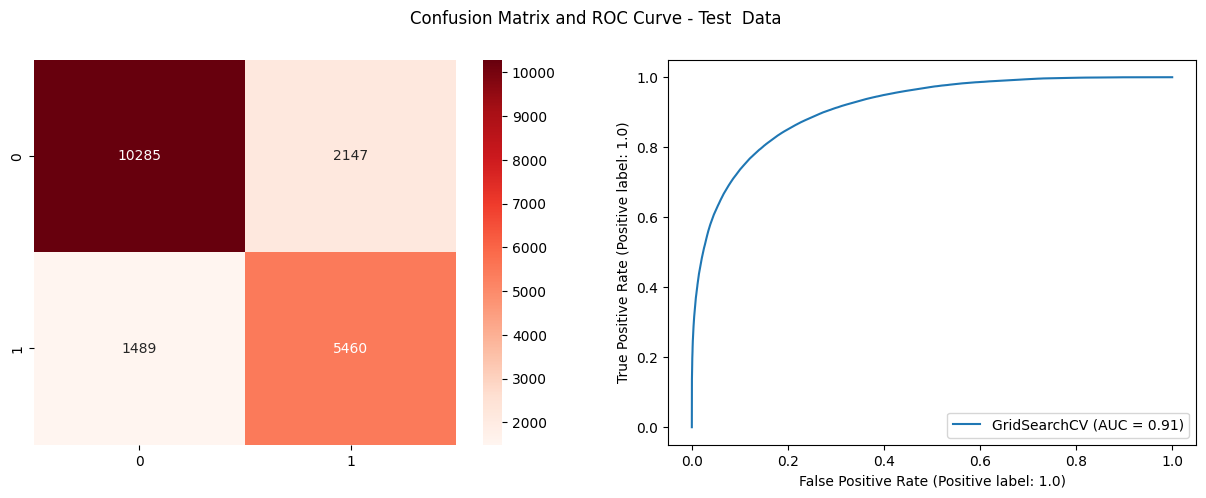

In [97]:
from sklearn.metrics import confusion_matrix,accuracy_score,RocCurveDisplay
cm=confusion_matrix(xgb_pred,y_test)
figure, axes = plt.subplots(1, 2, figsize = (15, 5))
figure.suptitle("Confusion Matrix and ROC Curve - Test  Data")
sns.heatmap(cm,annot=True,cmap="Reds",ax=axes[0],fmt='g')
roc1 = RocCurveDisplay.from_estimator(grid_search, X_train, y_train, ax=axes[1])



In [98]:
import numpy as np
from sklearn.metrics import mean_squared_error, median_absolute_error

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))

# Calculate MedAE
medae = median_absolute_error(xgb_pred, y_test)

# Calculate AE
ae = np.mean(np.abs(y_test - xgb_pred))

mse = mean_squared_error(y_test, xgb_pred)

# Print the results
print("RMSE:", rmse)
print("MedAE:", medae)
print("AE:", ae)
print("mse:", mse)

RMSE: 0.433135566142343
MedAE: 0.0
AE: 0.187606418657448
mse: 0.187606418657448


In [99]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
RX = score_encode.iloc[:,0:12]
RY = score_encode.iloc[:,12]

seed = 7
test_size = 0.33
RX_train, RX_test, Ry_train, Ry_test = train_test_split(RX, RY, test_size=test_size, random_state=seed)

rf = RandomForestClassifier()


# Define the hyperparameters to search over
param_dist = {'n_estimators': [25, 50, 75, 100, 125, 150, 175, 200],
              'max_features': ['sqrt', 'log2'],
              'max_depth': [None, 10, 20, 30],
              'min_samples_split': [2,3,4,5,6,7,8,9,10],
              'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10]}

# Define the random search object
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=20, cv=5, n_jobs=-1)

# Fit the random search object to the training data
random_search.fit(RX_train, Ry_train)

# Print the best hyperparameters found
print(random_search.best_params_)

# Evaluate the model with the best hyperparameters on the testing data
best_model = random_search.best_estimator_
random_preds = best_model.predict(X_test)
score = best_model.score(X_test, y_test)
print(score)

# model2.fit(RX_train, Ry_train)

# Ry_pred = model2.predict(RX_test)
# random_preds = [round(value) for value in Ry_pred]

accuracy = accuracy_score(RX_test, random_preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))






{'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 20}
0.8106392858985605
Accuracy: 81.06%


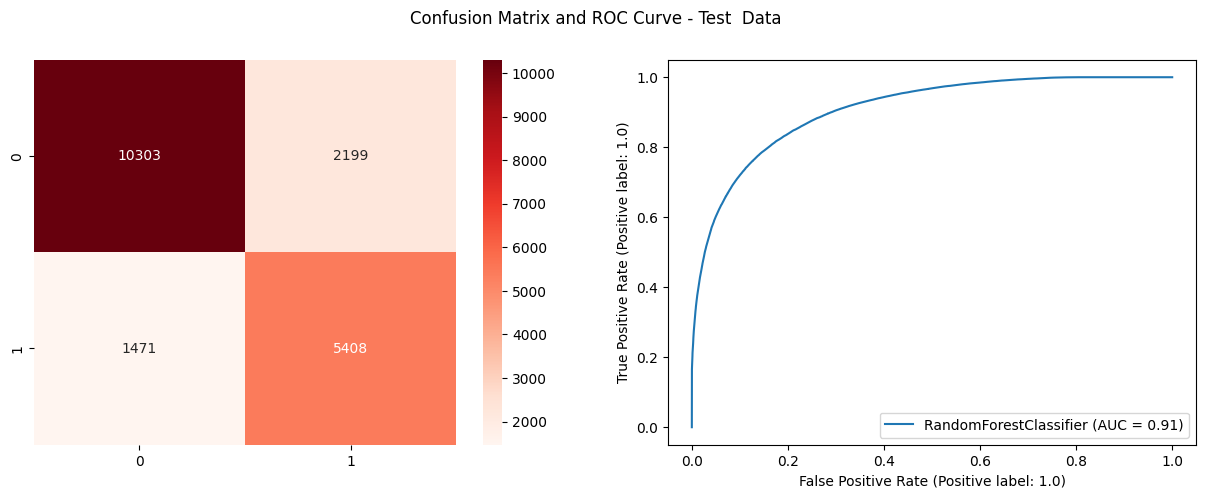

In [100]:
cm1=confusion_matrix(random_preds,Ry_test)
figure, axes = plt.subplots(1, 2, figsize = (15, 5))
figure.suptitle("Confusion Matrix and ROC Curve - Test  Data")
sns.heatmap(cm1,annot=True,cmap="Reds",ax=axes[0],fmt='g')
roc1 = RocCurveDisplay.from_estimator(best_model, RX_train, Ry_train, ax=axes[1])

In [87]:
import numpy as np
from sklearn.metrics import mean_squared_error, median_absolute_error

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(Ry_test, random_preds))

# Calculate MedAE
medae = median_absolute_error(Ry_test, random_preds)

# Calculate AE
ae = np.mean(np.abs(Ry_test - random_preds))

mse = mean_squared_error(Ry_test, random_preds)
# Print the results
print("RMSE:", rmse)
print("MedAE:", medae)
print("AE:", ae)
print(mse)

RMSE: 0.43355230034127484
MedAE: 0.0
AE: 0.18796759713121097
0.18796759713121097


In [144]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd

score_encode.columns
score_encode['MeteredTimeLimit'] = score_encode['MeteredTimeLimit'].astype(float)

# score_encode.drop(["MeteredTimeLimit"], axis=1, inplace=True)

X = score_encode.iloc[:,0:12]
Y = score_encode.iloc[:,12]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Convert the data into a LGB Dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# print(train_data.get_data().dtypes)

# Set the parameters for the LGB model
params = {'num_leaves': 31, 'objective': 'binary', 'metric': 'binary_logloss'}

# Train the LGB model
num_round = 100
model3 = lgb.train(params, train_data, num_round)

# Make predictions on the test set and evaluate the model performance
y_pred = model3.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
y_pred_class = [1 if x >= 0.5 else 0 for x in y_pred]
acc_score = accuracy_score(y_test, y_pred_class)
print("Accuracy: %.2f%%" % (acc_score * 100.0))
print('MSE: {:.2f}'.format(mse))

[LightGBM] [Info] Number of positive: 17865, number of negative: 28178
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 618
[LightGBM] [Info] Number of data points in the train set: 46043, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.388007 -> initscore=-0.455698
[LightGBM] [Info] Start training from score -0.455698
Accuracy: 79.18%
MSE: 0.15


In [172]:
score_encode["MeteredTimeLimit"].value_counts()

2.00     41168
4.00     13392
1.00      1572
10.00      496
0.25       483
0.50       443
Name: MeteredTimeLimit, dtype: Int64

In [156]:
import lightgbm as lgb
from sklearn.metrics import roc_curve
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from lightgbm import LGBMClassifier

score_encode['MeteredTimeLimit'] = score_encode['MeteredTimeLimit'].astype(float)

X = score_encode.iloc[:,0:12]
Y = score_encode.iloc[:,12]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
params = {'num_leaves': 31, 'objective': 'binary', 'metric': 'binary_logloss'}

# Create a LightGBM Booster object
num_round = 100
booster = lgb.train(params,train_set=lgb.Dataset(X_train, y_train))

# Wrap the Booster object in a Scikit-learn LGBMClassifier object
estimator = LGBMClassifier(boosting_type='gbdt', objective='binary', n_estimators=100, learning_rate=0.1)

# Fit the LGBMClassifier object on the training data
estimator.fit(X_train, y_train)

y_pred = estimator.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
y_pred_class = [1 if x >= 0.5 else 0 for x in y_pred]
acc_score = accuracy_score(y_test, y_pred_class)
print("Accuracy: %.2f%%" % (acc_score * 100.0))
print('MSE: {:.2f}'.format(mse))

[LightGBM] [Info] Number of positive: 17865, number of negative: 28178
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 618
[LightGBM] [Info] Number of data points in the train set: 46043, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.388007 -> initscore=-0.455698
[LightGBM] [Info] Start training from score -0.455698
Accuracy: 79.18%
MSE: 0.21


In [158]:
import numpy as np
from sklearn.metrics import mean_squared_error, median_absolute_error

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_class))

# Calculate MedAE
medae = median_absolute_error(y_test, y_pred_class)

# Calculate AE
ae = np.mean(np.abs(y_test - y_pred_class))

# Print the results
print("RMSE:", rmse)
print("MedAE:", medae)
print("AE:", ae)

RMSE: 0.4462217958154045
MedAE: 0.0
AE: 0.19911389106072452


In [157]:
# Define the hyperparameter grid to search over
param_grid = {
    'num_leaves': [5, 7, 9, 10, 11 , 13, 15, 20, 25, 30],
    'learning_rate': [0.001, 0.01, 0.1, 1,  0.5],
    'n_estimators': [25, 50,75, 100, 125, 150, 200],
}

# Define the GridSearchCV object
grid_search = GridSearchCV(
    estimator,
    param_grid,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1,
)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)


# Print the best hyperparameters found
print("Best hyperparameters: ", grid_search.best_params_)

# Predict on the testing data using the best model
y_pred = grid_search.predict(X_test)

y_pred_class = [1 if x >= 0.5 else 0 for x in y_pred]
acc_score = accuracy_score(y_test, y_pred_class)
print("Accuracy: %.2f%%" % (acc_score * 100.0))

# # Calculate the ROC AUC score on the testing data
# auc = roc_auc_score(y_test, y_pred)
# print("ROC AUC score: ", auc)

Fitting 5 folds for each of 350 candidates, totalling 1750 fits
Best hyperparameters:  {'learning_rate': 0.5, 'n_estimators': 150, 'num_leaves': 30}
Accuracy: 80.09%


In [122]:
!pip install prettytable
from prettytable import PrettyTable

# Define the evaluation metrics for each model
xgb_metrics = {"RMSE":  0.4197, "Absolute Error": 0.1766, "MSE": 0.1796}
rf_metrics = {"RMSE": 0.4306, "Absolute Error": 0.1854, "MSE": 0.1854}
lgbm_metrics = {"RMSE": 0.4462, "Absolute Error": 0.1991, "MSE": 0.2184}

# Create a PrettyTable object with the column names
table = PrettyTable(["Model", "RMSE", "Absolute Error", "MSE"])

# Add the data for each model
table.add_row(["LSTM", xgb_metrics["RMSE"], xgb_metrics["Absolute Error"], xgb_metrics["MSE"]])
table.add_row(["XGB boost", rf_metrics["RMSE"], rf_metrics["Absolute Error"], rf_metrics["MSE"]])
table.add_row(["Random Forrest", lgbm_metrics["RMSE"], lgbm_metrics["Absolute Error"], lgbm_metrics["MSE"]])

# Set the alignment for each column
table.align["Model"] = "l"
table.align["RMSE"] = "r"
table.align["Absolute Error"] = "r"
table.align["MSE"] = "r"

# Display the table
print(table)

RMSE: 0.4462217958154045
MedAE: 0.0
AE: 0.19911389106072452

+----------------+--------+----------------+--------+
| Model          |   RMSE | Absolute Error |    MSE |
+----------------+--------+----------------+--------+
| LSTM           | 0.4197 |         0.1766 | 0.1796 |
| XGB boost      | 0.4306 |         0.1854 | 0.1854 |
| Random Forrest | 0.4462 |         0.1991 | 0.2184 |
+----------------+--------+----------------+--------+


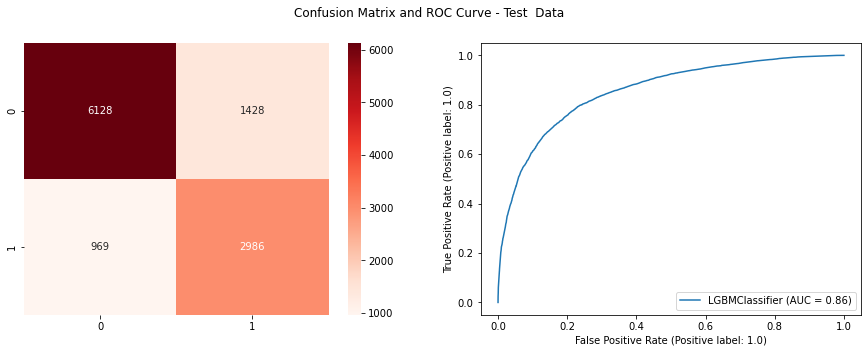

In [87]:
cm2=confusion_matrix(y_pred_class,y_test)
figure, axes = plt.subplots(1, 2, figsize = (15, 5))
figure.suptitle("Confusion Matrix and ROC Curve - Test  Data")
sns.heatmap(cm2,annot=True,cmap="Reds",ax=axes[0],fmt='g')
roc2 = RocCurveDisplay.from_estimator(estimator, X_train, y_train, ax=axes[1])

In [87]:
figure, axes = plt.subplots(3, 2, figsize = (15, 5))
figure.suptitle("Confusion Matrix and ROC Curve - Test  Data")
sns.heatmap(cm,annot=True,cmap="Reds",ax=axes[0],fmt='g')
roc1 = RocCurveDisplay.from_estimator(model, X_train, y_train, ax=axes[1])


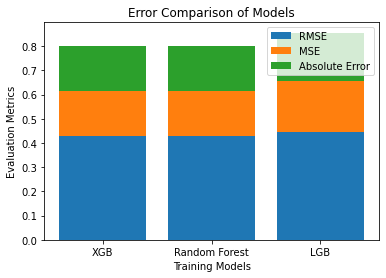

In [167]:
import matplotlib.pyplot as plt
import numpy as np

# Define the data for the stacked bar chart
rmse = [0.42976694402671967, 0.43062366383133693, 0.4462217958154045]
mse = [0.1846996261780656, 0.18543673985152426, 0.21]
abs_error = [0.1846996261780656, 0.18543673985152426, 0.19911389106072452]
models = ['XGB', 'Random Forest', 'LGB']

# Define the colors for the stacked bars
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Define the positions of the bars on the x-axis
bar_positions = np.arange(len(models))

# Create the stacked bar chart
plt.bar(bar_positions, rmse, color=colors[0], label='RMSE')
plt.bar(bar_positions, mse, bottom=rmse, color=colors[1], label='MSE')
plt.bar(bar_positions, abs_error, bottom=np.array(rmse)+np.array(mse), color=colors[2], label='Absolute Error')

# Add labels and ticks
plt.legend()
plt.xticks(bar_positions, models)
plt.xlabel('Training Models')
plt.ylabel('Evaluation Metrics')
plt.title('Error Comparison of Models')


# Show the plot
plt.show()

In [88]:
# import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import GridSearchCV

lX = score_encode.iloc[:,0:12]
lY = score_encode.iloc[:,12]

seed = 7
test_size = 0.33
lX_train, lX_test, ly_train, ly_test = train_test_split(lX, lY, test_size=test_size, random_state=seed)
lX_test = np.asarray(lX_test)
ly_test= np.asarray(ly_test)
lX_train = np.asarray(lX_train).astype(np.float32)
ly_train = np.asarray(ly_train).astype(np.float32)
print(lX_train.shape)

# Reshape the input data to have shape [batch_size, timesteps, feature]
lX_train = np.reshape(lX_train, (lX_train.shape[0], lX_train.shape[1], 1))

# Define the LSTM model
def create_model(units_lstm=128, dropout_rate=0.5):
    model = Sequential()
    model.add(LSTM(units=units_lstm, input_shape=(12,1), return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units_lstm//2))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Set hyperparameters to tune
param_grid = {
    'units_lstm': [64, 128, 256],
    'dropout_rate': [0.2, 0.5, 0.8]
}

# Create and fit the GridSearchCV object
model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_search.fit(lX_train, ly_train)

# Print the best hyperparameters and corresponding score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
loss, accuracy = best_model.evaluate(lX_test, ly_test)

# # Make predictions on new data using the best model
# new_data = np.random.rand(1, 50, 1)
# predictions = best_model.predict(new_data)


Best parameters:{'units_lstm': 128, 'dropout_rate': 0.5}
